In [46]:
import pandas as pd
import numpy as np
import os

from tiingo import TiingoClient

In [9]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [10]:
# doc: https://tiingo-python.readthedocs.io/en/latest/readme.html#usage

In [11]:
config = {}
config['session'] = True


In [12]:
client = TiingoClient(config)

In [13]:
ticker_history = client.get_dataframe("TSLA")

In [13]:
ticker_metadata

{'name': 'Tesla Motors Inc',
 'startDate': '2010-06-29',
 'ticker': 'TSLA',
 'exchangeCode': 'NASDAQ',
 'description': 'Tesla Motors, Inc. (Tesla) designs, develops, manufactures and sells electric vehicles and advanced electric vehicle powertrain components. Tesla owns its sales and service network. The Company is engaged in commercially producing a federally-compliant electric vehicle, the Tesla Roadster. addition to developing its Model S and future vehicle manufacturing capabilities at the Tesla Factory, the Company is designing, developing and manufacturing lithium-ion battery packs, electric motors, gearboxes and components both for its vehicles and for its original equipment manufacturer customers. These activities occur at its electric powertrain manufacturing facility in Palo Alto, California and at the Tesla Factory. The Company provides services for the development of electric powertrain components and sells electric powertrain components to other automotive manufacturers.',

In [14]:
ticker_history = client.get_dataframe("TSLA", metric_name='adjClose')

In [15]:
vol_history = client.get_dataframe(['TSLA'],
                                      frequency='daily',
                                      metric_name='volume',
                                      startDate='2015-01-01',
                                      endDate='2020-05-17').reset_index()
vol_history.columns = ['date', 'vol']
vol_history['dow'] = vol_history.date.apply(lambda x: x.strftime('%w'))
vol_history['year'] = vol_history.date.apply(lambda x: x.strftime('%Y'))
vol_history['week'] = vol_history.date.apply(lambda x: x.strftime('%U'))
vol_history.date = vol_history.date.apply(lambda x: x.date().strftime('%Y-%m-%d'))

In [16]:
vol_history.head()

,date,vol,dow,year,week
0,2015-01-02,4764443,5,2015,00
1,2015-01-05,5368477,1,2015,01
2,2015-01-06,6261936,2,2015,01
3,2015-01-07,2968390,3,2015,01
4,2015-01-08,3442509,4,2015,01


In [17]:
close_history = client.get_dataframe(['TSLA'],
                                      frequency='daily',
                                      metric_name='close',
                                      startDate='2015-01-01',
                                      endDate='2020-05-17').reset_index()
close_history.columns = ['date', 'close']
close_history['dow'] = close_history.date.apply(lambda x: x.strftime('%w'))
close_history['year'] = close_history.date.apply(lambda x: x.strftime('%Y'))
close_history['week'] = close_history.date.apply(lambda x: x.strftime('%U'))
close_history.date = close_history.date.apply(lambda x: x.date().strftime('%Y-%m-%d'))

In [18]:
tsla = pd.merge(close_history, vol_history, how='inner', on=['date','year', 'week', 'dow'])
tsla.head()

,date,close,dow,year,week,vol
0,2015-01-02,219.310,5,2015,00,4764443
1,2015-01-05,210.090,1,2015,01,5368477
2,2015-01-06,211.280,2,2015,01,6261936
3,2015-01-07,210.950,3,2015,01,2968390
4,2015-01-08,210.615,4,2015,01,3442509


In [34]:
tsla_gb = tsla.drop(['date'], axis=1).groupby(['year', 'week', 'dow']).agg({'close': 'mean', 'vol': 'mean'})

In [35]:
tsla_gb_s = tsla_gb.copy()

In [36]:
tsla_gb_s.head()

close      vol
year week dow                  
2015 00   5    219.310  4764443
     01   1    210.090  5368477
          2    211.280  6261936
          3    210.950  2968390
          4    210.615  3442509

In [37]:
tsla_gb_s = tsla_gb_s.unstack('dow').reset_index()
tsla_gb_s.columns = ['_'.join(i) for i in tsla_gb_s.columns]
tsla_gb_s.head()


,year_,week_,close_1,close_2,close_3,close_4,close_5,vol_1,vol_2,vol_3,vol_4,vol_5
0,2015,00,NaN,NaN,NaN,NaN,219.31,NaN,NaN,NaN,NaN,4764443.0
1,2015,01,210.09,211.28,210.95,210.615,206.66,5368477.0,6261936.0,2968390.0,3442509.0,4580722.0
2,2015,02,202.21,204.25,192.69,191.870,193.07,5950280.0,4477320.0,11551855.0,5216524.0,3603158.0
3,2015,03,NaN,191.93,196.57,201.620,201.29,NaN,4503182.0,4153043.0,4116905.0,3442371.0
4,2015,04,206.55,205.98,199.37,205.200,203.60,3234522.0,2781024.0,3149606.0,3548106.0,3006959.0


In [39]:
for i in range(5):
    tsla_gb_s['close_51'] = tsla_gb_s['close_5'].shift()
    tsla_gb_s['vol_51'] = tsla_gb_s['vol_5'].shift()

    tsla_gb_s.loc[tsla_gb_s['close_1'].isna(), 'close_1'] = tsla_gb_s['close_51']
    tsla_gb_s.loc[tsla_gb_s['close_2'].isna(), 'close_2'] = tsla_gb_s['close_1']
    tsla_gb_s.loc[tsla_gb_s['close_3'].isna(), 'close_3'] = tsla_gb_s['close_2']
    tsla_gb_s.loc[tsla_gb_s['close_4'].isna(), 'close_4'] = tsla_gb_s['close_3']
    tsla_gb_s.loc[tsla_gb_s['close_5'].isna(), 'close_5'] = tsla_gb_s['close_4']

    tsla_gb_s.loc[tsla_gb_s['vol_1'].isna(), 'vol_1'] = tsla_gb_s['vol_51']
    tsla_gb_s.loc[tsla_gb_s['vol_2'].isna(), 'vol_2'] = tsla_gb_s['vol_1']
    tsla_gb_s.loc[tsla_gb_s['vol_3'].isna(), 'vol_3'] = tsla_gb_s['vol_2']
    tsla_gb_s.loc[tsla_gb_s['vol_4'].isna(), 'vol_4'] = tsla_gb_s['vol_3']
    tsla_gb_s.loc[tsla_gb_s['vol_5'].isna(), 'vol_5'] = tsla_gb_s['vol_4']
tsla_gb_s = tsla_gb_s.drop(['vol_51'], axis=1)
tsla_gb_s = tsla_gb_s.loc[~(tsla_gb_s.close_1.isna())]


In [66]:
tsla_gb_s['prev_week'] = tsla_gb_s.close_5.shift()
tsla_gb_s['inc/dec'] = tsla_gb_s.close_5 - tsla_gb_s.prev_week
tsla_gb_s['percent'] = tsla_gb_s['inc/dec'] / tsla_gb_s.prev_week * 100
tsla_gb_s.head()

,year_,week_,close_1,close_2,close_3,close_4,close_5,vol_1,vol_2,vol_3,vol_4,vol_5,close_51,prev_week,inc/dec,percent
1,2015,01,210.09,211.28,210.95,210.615,206.66,5368477.0,6261936.0,2968390.0,3442509.0,4580722.0,219.31,NaN,NaN,NaN
2,2015,02,202.21,204.25,192.69,191.870,193.07,5950280.0,4477320.0,11551855.0,5216524.0,3603158.0,206.66,206.66,-13.59,-6.576019
3,2015,03,193.07,191.93,196.57,201.620,201.29,3603158.0,4503182.0,4153043.0,4116905.0,3442371.0,193.07,193.07,8.22,4.257523
4,2015,04,206.55,205.98,199.37,205.200,203.60,3234522.0,2781024.0,3149606.0,3548106.0,3006959.0,201.29,201.29,2.31,1.147598
5,2015,05,210.94,218.36,218.55,220.990,217.36,4149186.0,4826244.0,3305377.0,3522947.0,3243931.0,203.60,203.60,13.76,6.758350


In [26]:
tsla_gb_s.to_csv('./Data/Tesla/TSLA_price.csv')

In [51]:
files = ['./Data/Tesla/Score/'+i for i in os.listdir('./Data/Tesla/Score/')]

In [56]:
dfs = []
for i in files:
    df = pd.read_csv(i)
    dfs.append(df)
    print(df.shape)
df = pd.concat(dfs)

(80, 5)
(92, 5)
(92, 5)
(78, 5)
(79, 5)
(91, 5)
(41, 5)
(17, 5)


In [68]:
df['date'] = pd.to_datetime(df['date'])
df['dow'] = df.date.apply(lambda x: x.strftime('%w'))
df['year'] = df.date.apply(lambda x: x.strftime('%Y'))
df['week'] = df.date.apply(lambda x: x.strftime('%U'))
df.head()

,Title,url,content,date,compound,dow,year,week
0,Tesla factory worker: Elon Musk doesn't have w...,https://www.cnn.com/2020/05/14/tech/tesla-work...,Afterwinning a public standoffwith California'...,2020-05-14,0.9324,4,2020,19
1,Elon Musk is using his power to be selfish,https://www.cnn.com/2020/05/01/opinions/elon-m...,"His words were tone deaf and, for someone with...",2020-05-01,-0.2732,5,2020,17
2,Jerome Powell is asking for help. Will anyone ...,https://www.cnn.com/2020/05/14/investing/prema...,A version of this story first appeared in CNN ...,2020-05-14,0.9048,4,2020,19
3,Analysis: What happened to Elon Musk?,https://www.cnn.com/2020/05/13/business/elon-m...,Musk deftly played the part of a new kind of C...,2020-05-13,0.9911,3,2020,19
4,"After years without turning a profit, Tesla is...",https://www.cnn.com/2020/05/13/business/tesla-...,It is a remarkable achievement for a company t...,2020-05-13,0.9985,3,2020,19


In [69]:
compound = df.groupby(['year', 'week'], as_index=False).agg({'compound': 'sum'})
compound.head()

,year,week,compound
0,2016,31,0.9783
1,2018,23,0.8946
2,2018,24,0.9995
3,2018,25,2.0195
4,2018,26,0.8809


In [74]:
tsla_gb_s.columns = [i.strip('_') for i in tsla_gb_s.columns]
tsla_gb_s.head()

,year,week,close_1,close_2,close_3,close_4,close_5,vol_1,vol_2,vol_3,vol_4,vol_5,close_51,prev_week,inc/dec,percent
1,2015,01,210.09,211.28,210.95,210.615,206.66,5368477.0,6261936.0,2968390.0,3442509.0,4580722.0,219.31,NaN,NaN,NaN
2,2015,02,202.21,204.25,192.69,191.870,193.07,5950280.0,4477320.0,11551855.0,5216524.0,3603158.0,206.66,206.66,-13.59,-6.576019
3,2015,03,193.07,191.93,196.57,201.620,201.29,3603158.0,4503182.0,4153043.0,4116905.0,3442371.0,193.07,193.07,8.22,4.257523
4,2015,04,206.55,205.98,199.37,205.200,203.60,3234522.0,2781024.0,3149606.0,3548106.0,3006959.0,201.29,201.29,2.31,1.147598
5,2015,05,210.94,218.36,218.55,220.990,217.36,4149186.0,4826244.0,3305377.0,3522947.0,3243931.0,203.60,203.60,13.76,6.758350


In [78]:
merged = pd.merge(tsla_gb_s, compound, how='left', on=['year', 'week'])

In [88]:
merged = merged.iloc[179:, :]
merged = merged.fillna(0)

In [91]:
merged = merged.drop(['close_51'], axis=1)

In [102]:
merged.vol_1 = merged.vol_1/10000
merged.vol_2 = merged.vol_2/10000
merged.vol_3 = merged.vol_3/10000
merged.vol_4 = merged.vol_4/10000
merged.vol_5 = merged.vol_5/10000
merged.head()

,year,week,close_1,close_2,close_3,close_4,close_5,vol_1,vol_2,vol_3,vol_4,vol_5,percent,compound
179,2018,23,332.10,342.77,344.78,357.72,358.17,1318.3473,2234.7403,946.9804,1098.1023,1084.8254,12.752629,0.8946
180,2018,24,370.83,352.55,362.22,347.51,333.63,1207.3226,1276.1903,838.3656,796.7145,1026.6059,-6.851495,0.9995
181,2018,25,333.01,342.00,344.50,349.93,342.95,693.1304,745.2487,833.3727,839.8005,649.2396,2.793514,2.0195
182,2018,26,335.07,310.86,310.86,309.16,308.90,1875.9765,1228.2638,1228.2638,1747.6374,886.5451,-9.928561,0.8809
183,2018,27,318.51,322.47,318.96,316.71,318.87,759.6753,947.1498,488.4076,572.1166,587.5770,3.227582,0.4301


In [100]:
merged = merged.drop(['prev_week', 'inc/dec'], axis=1)

In [103]:
# compound.to_csv('./Data/Tesla/Content/AllData.csv')
merged.to_csv('./Data/Tesla/Content/AllDataMerged.csv', index=False)

In [120]:
tmp.to_csv('./Data/Tesla/TSLAStocksPrice.csv')

In [119]:
tmp = close_history[['date', 'close']].set_index('date')

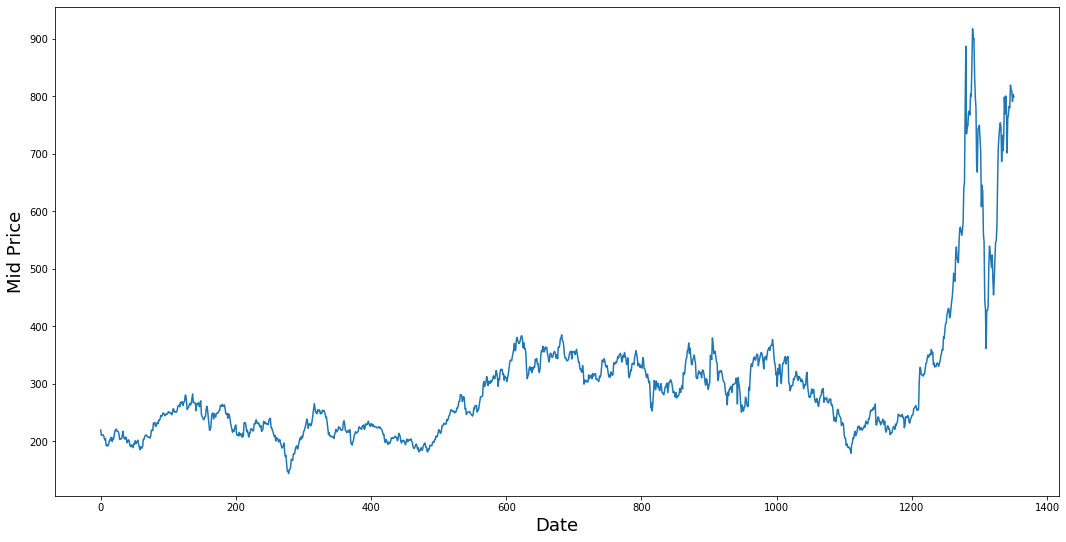

In [115]:
plt.figure(figsize = (18,9))
plt.plot(range(tmp.shape[0]),tmp['close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()